In [3]:
!pip install kagglehub
!pip install torchvision

In [4]:
import kagglehub


# Download latest version
path = kagglehub.dataset_download("jidhumohan/mnist-png")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/jidhumohan/mnist-png/versions/1


In [5]:
path+="/mnist_png"

In [6]:
train_path = path+"/training"
test_path = path+"/testing"

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [51]:
def add_gaussian_noise(image,noise=0.05):
    # Generate random Gaussian noise with mean 0 and standard deviation 0.1
    noise = torch.randn_like(image) * noise
    # Add noise to the image
    noisy_image = image + noise
    # Clip pixel values to be within the valid range [0, 1]
    noisy_image = torch.clamp(noisy_image, 0, 1)
    return noisy_image

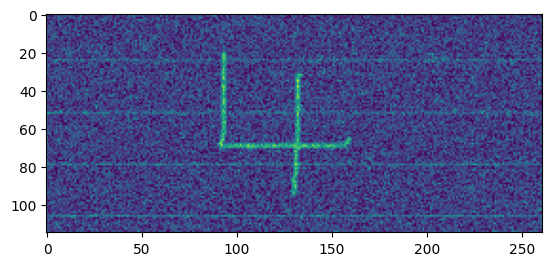

In [54]:
img = transforms.ToTensor()(Image.open('./test.jpeg').convert('L'))
plt.imshow(img.permute(1,2,0))
plt.imshow(add_gaussian_noise(img,noise=0.05).permute(1,2,0))

In [8]:
def create_dataset_loader(path ,transform=None, batch_size=16, shuffle=True, number_of_channels = 3,imageheight = 28,imagewidth=28):
  if (transform == None):
    transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Resize((imagewidth,imageheight))
    ])
  dataset = datasets.ImageFolder(path, transform=transform)
  dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
  return dataloader


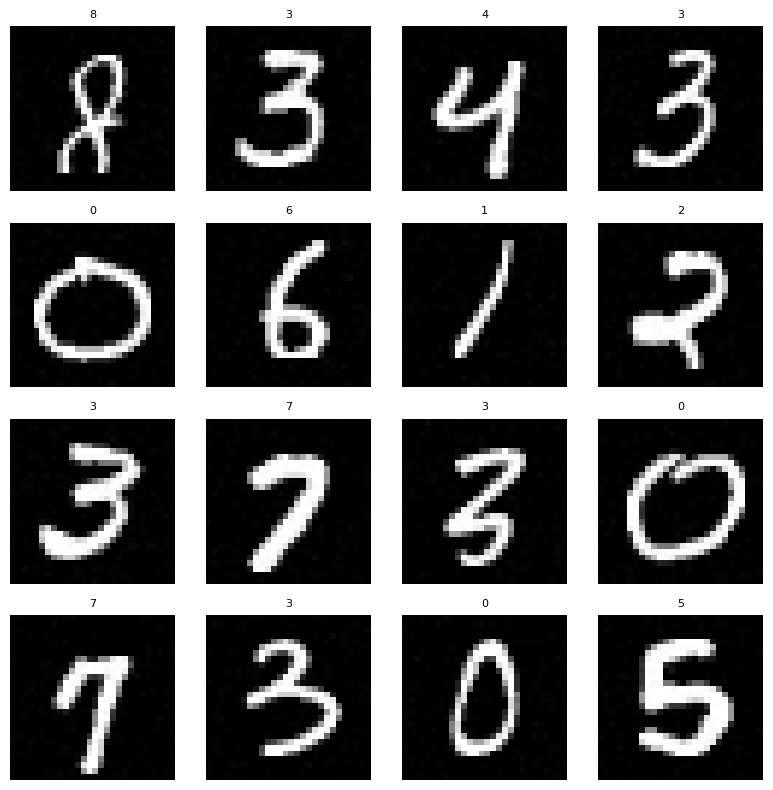

"fig, axs = plt.subplots(3, 4, figsize=(12, 8))\nfor i in range(4):\n    img = images[i]\n    for j in range(3):\n        ax = axs[j, i]\n        ax.imshow(img[j], cmap='gray')\n        ax.axis('off')\n        ax.set_title(f'Channel {j+1}', fontsize=8)\nplt.tight_layout()\nplt.show()"

In [86]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Assuming 'path' is already defined from the previous cells

train_transform = transforms.Compose([
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomRotation(20),
     transforms.ToTensor(),
    transforms.Grayscale(num_output_channels=1), #turn it to grey
    transforms.RandomAutocontrast(),
    #transforms.RandomRotation(25),

    transforms.Lambda(add_gaussian_noise),

    transforms.Resize((28, 28))
])

#dataset_train = datasets.ImageFolder(train_path, transform=train_transform)
#dataloader_train = DataLoader(dataset_train, batch_size=16, shuffle=True)
dataloader_train = create_dataset_loader(train_path, transform = train_transform)
images, labels = next(iter(dataloader_train))

fig, axs = plt.subplots(4, 4, figsize=(8, 8))
for i, (img, label) in enumerate(zip(images, labels)):
    #print(img.shape)
    ax = axs[i // 4, i % 4]
    ax.imshow(img.permute(1, 2, 0),cmap="gray")
    ax.axis('off')
    ax.set_title(dataloader_train.dataset.classes[label], fontsize=8)
plt.tight_layout()
plt.show()

# Show each channel separately
"""fig, axs = plt.subplots(3, 4, figsize=(12, 8))
for i in range(4):
    img = images[i]
    for j in range(3):
        ax = axs[j, i]
        ax.imshow(img[j], cmap='gray')
        ax.axis('off')
        ax.set_title(f'Channel {j+1}', fontsize=8)
plt.tight_layout()
plt.show()"""

In [10]:
def dim_after_cnn(input_size, kernel_size, padding_size, stride):
    return (input_size + 2*padding_size - kernel_size)//stride +1

In [11]:
dim_after_cnn(13,3,1,1)

13

In [11]:
!pip install torch_xla

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.6/90.6 MB 9.2 MB/s eta 0:00:00


In [12]:
# prompt: if cuda avaiilable pytorch use it

import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ... rest of your code ...

Using device: cuda


In [92]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import confusion_matrix
import seaborn as sns
import torch.functional as F
import torch
import torch.nn.init as init
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class CNN_Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extract= nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=1), #16x 26x26
            nn.ELU(),
            nn.AvgPool2d(2,2), #16x13x13
            nn.Conv2d(16,32,kernel_size=3, padding=1), #32x13x13
            nn.ELU(),
            nn.AvgPool2d(2,2) , #32x6x6
            nn.Conv2d(32,64,kernel_size=3, padding =1) ,
            nn.ELU(),
            nn.AvgPool2d(1,1) ,
            nn.Conv2d(64,64,kernel_size=3, padding =1) ,
            nn.ELU(),
            nn.AvgPool2d(1,1) ,
        )
        self.bn1 = nn.BatchNorm2d(64)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*6*6, 128),
            nn.ELU(),
            nn.Linear(128, 64),
            nn.ELU(),
            nn.Linear(64,10),
            nn.Softmax(dim=1)
        )
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def forward(self,x):
        x = self.feature_extract(x)
        x= self.bn1(x)
        x= self.classifier(x)
        return x
model = CNN_Model().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

In [93]:
# prompt: i loaded the trainig data : dataset_train = datasets.ImageFolder(train_path, transform=train_transform)
# dataloader_train = DataLoader(dataset_train, batch_size=16, shuffle=True)
# images, labels = next(iter(dataloader_train)) , i can load the test data from test_path, i want to split it to validation dataset and testing dataset

from torch.utils.data import random_split

# Assuming test_transform is defined similarly to train_transform
test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Resize((28, 28))
])

dataset_test = datasets.ImageFolder(test_path, transform=test_transform)
# Define the split ratio (e.g., 80% for validation, 20% for testing)
validation_ratio = 0.5
validation_size = int(len(dataset_test) * validation_ratio)
test_size = len(dataset_test) - validation_size

# Split the dataset
dataset_validation, dataset_testing = random_split(dataset_test, [validation_size, test_size])

# Create DataLoaders for validation and testing
dataloader_validation = DataLoader(dataset_validation, batch_size=16, shuffle=True)
dataloader_testing = DataLoader(dataset_testing, batch_size=16, shuffle=True)

print(f"Validation dataset size: {len(dataset_validation)}")
print(f"Testing dataset size: {len(dataset_testing)}")

Validation dataset size: 5000
Testing dataset size: 5000


Epoch 1/10, Train Loss: 1.6260, Train Accuracy: 0.8346, Val Loss: 1.5196, Val Accuracy: 0.9408
Epoch 2/10, Train Loss: 1.5347, Train Accuracy: 0.9262, Val Loss: 1.5145, Val Accuracy: 0.9470
Epoch 3/10, Train Loss: 1.5282, Train Accuracy: 0.9328, Val Loss: 1.5205, Val Accuracy: 0.9404
Epoch 4/10, Train Loss: 1.5221, Train Accuracy: 0.9389, Val Loss: 1.5111, Val Accuracy: 0.9504
Epoch 5/10, Train Loss: 1.5177, Train Accuracy: 0.9432, Val Loss: 1.5090, Val Accuracy: 0.9522
Epoch 6/10, Train Loss: 1.5062, Train Accuracy: 0.9549, Val Loss: 1.4924, Val Accuracy: 0.9686
Epoch 7/10, Train Loss: 1.4961, Train Accuracy: 0.9651, Val Loss: 1.4888, Val Accuracy: 0.9726
Epoch 8/10, Train Loss: 1.4923, Train Accuracy: 0.9688, Val Loss: 1.4879, Val Accuracy: 0.9734
Epoch 9/10, Train Loss: 1.4906, Train Accuracy: 0.9705, Val Loss: 1.4836, Val Accuracy: 0.9774
Epoch 10/10, Train Loss: 1.4877, Train Accuracy: 0.9734, Val Loss: 1.4835, Val Accuracy: 0.9776


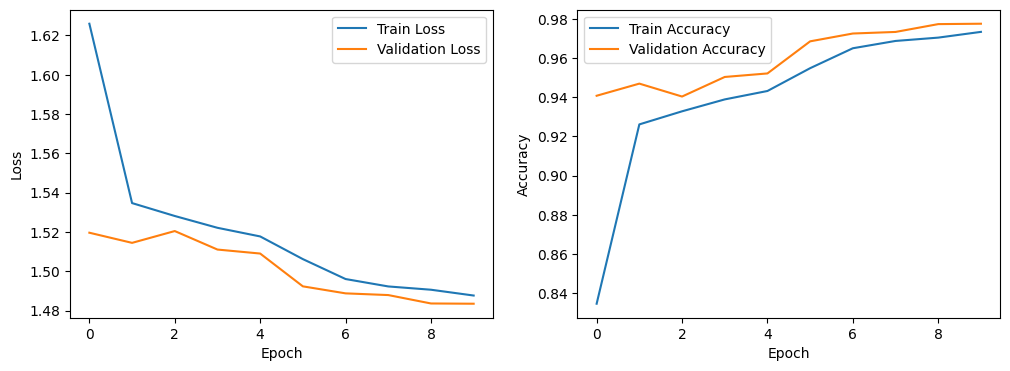

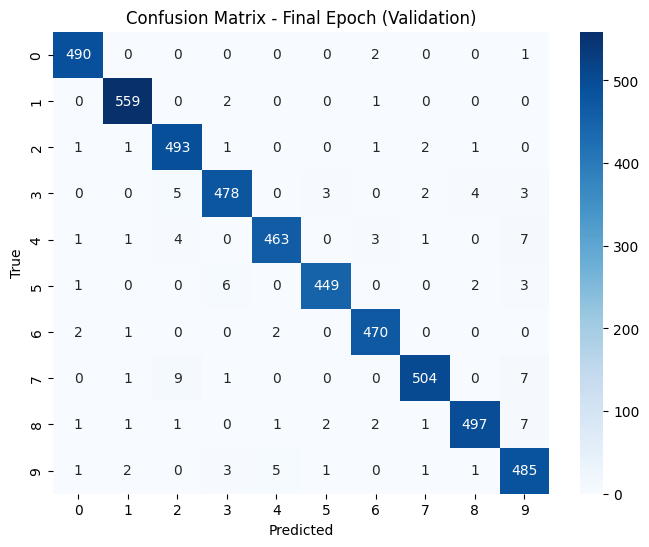

In [94]:

import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import confusion_matrix
import torch.functional as F
import torch
from torch.utils.data import random_split
import os
# ... (rest of your existing code)

def train_model(model, train_loader, validation_loader, num_epochs, criterion, optimizer, scheduler, device=device,patience=1):
    model.to(device)
    best_val_acc = 0
    epoch_losses = []
    epoch_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train() #training mode
        running_loss = 0.0
        epoch_preds = []
        epoch_labels = []
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, preds = outputs.max(1)
            epoch_preds.extend(preds.cpu().numpy())
            epoch_labels.extend(labels.cpu().numpy())
        scheduler.step()
        epoch_loss = running_loss / len(train_loader)
        epoch_losses.append(epoch_loss)
        # Calculate accuracy
        accuracy = np.mean(np.array(epoch_preds) == np.array(epoch_labels))
        epoch_accuracies.append(accuracy)

        # Validation
        model.eval()
        val_running_loss = 0.0
        val_epoch_preds = []
        val_epoch_labels = []
        with torch.no_grad():
            for inputs, labels in validation_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, preds = outputs.max(1)
                val_epoch_preds.extend(preds.cpu().numpy())
                val_epoch_labels.extend(labels.cpu().numpy())

        val_epoch_loss = val_running_loss / len(validation_loader)
        val_losses.append(val_epoch_loss)
        val_accuracy = np.mean(np.array(val_epoch_preds) == np.array(val_epoch_labels))
        val_accuracies.append(val_accuracy)
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {accuracy:.4f}, Val Loss: {val_epoch_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    # Plotting
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epoch_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epoch_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

    # Confusion Matrix (on validation data)
    cm = confusion_matrix(val_epoch_labels, val_epoch_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_loader.dataset.classes, yticklabels=train_loader.dataset.classes) # Use dataset_test classes
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix - Final Epoch (Validation)')
    plt.show()

    return epoch_losses, epoch_accuracies, val_losses, val_accuracies




# Example usage
num_epochs = 10 # Adjust the number of epochs as needed
epoch_losses, epoch_accuracies, val_losses, val_accuracies = train_model(model, dataloader_train, dataloader_validation, num_epochs, criterion, optimizer, scheduler)

Epoch 1/10, Train Loss: 1.4854, Train Accuracy: 0.9758, Val Loss: 1.4826, Val Accuracy: 0.9788
Epoch 2/10, Train Loss: 1.4859, Train Accuracy: 0.9752, Val Loss: 1.4821, Val Accuracy: 0.9792
Epoch 3/10, Train Loss: 1.4854, Train Accuracy: 0.9757, Val Loss: 1.4828, Val Accuracy: 0.9782
Epoch 4/10, Train Loss: 1.4856, Train Accuracy: 0.9755, Val Loss: 1.4823, Val Accuracy: 0.9788
Epoch 5/10, Train Loss: 1.4856, Train Accuracy: 0.9755, Val Loss: 1.4827, Val Accuracy: 0.9788
Epoch 6/10, Train Loss: 1.4853, Train Accuracy: 0.9758, Val Loss: 1.4827, Val Accuracy: 0.9786
Epoch 7/10, Train Loss: 1.4854, Train Accuracy: 0.9757, Val Loss: 1.4818, Val Accuracy: 0.9794
Epoch 8/10, Train Loss: 1.4857, Train Accuracy: 0.9754, Val Loss: 1.4830, Val Accuracy: 0.9782
Epoch 9/10, Train Loss: 1.4858, Train Accuracy: 0.9753, Val Loss: 1.4817, Val Accuracy: 0.9792
Epoch 10/10, Train Loss: 1.4861, Train Accuracy: 0.9750, Val Loss: 1.4819, Val Accuracy: 0.9792


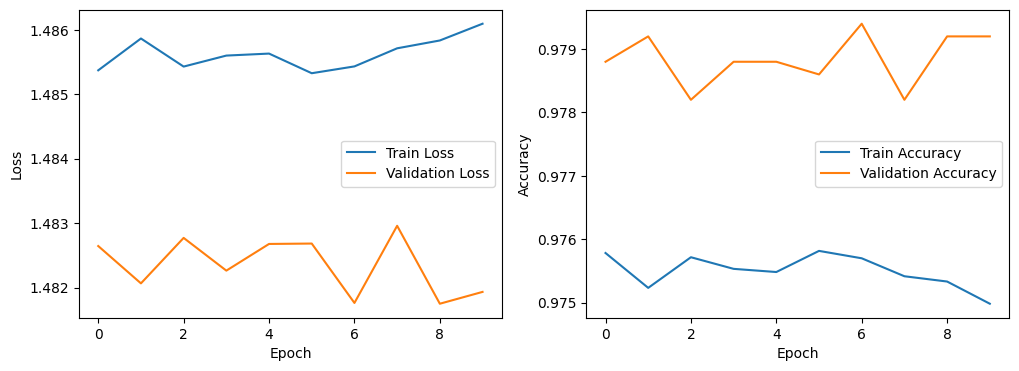

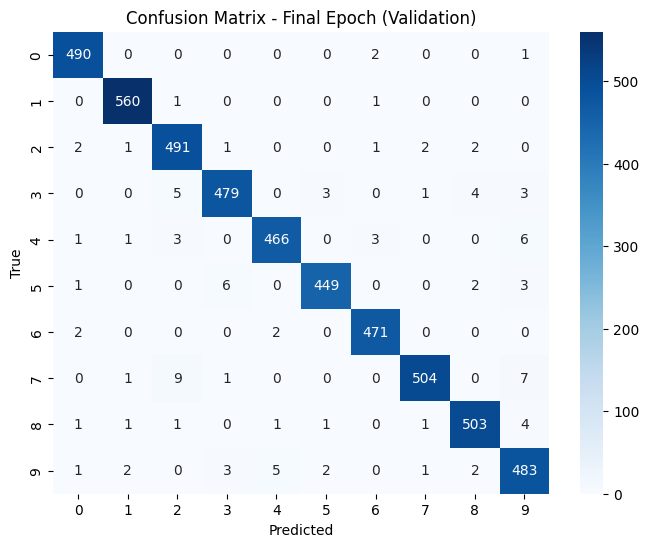

In [98]:
epoch_losses, epoch_accuracies, val_losses, val_accuracies = train_model(model, dataloader_train, dataloader_validation, 10, criterion, optimizer, scheduler)

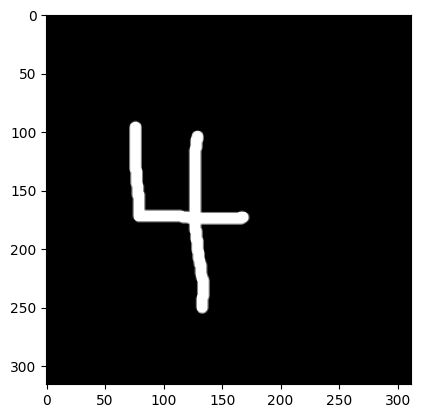

In [37]:
from PIL import Image

path_img = "./test.png"
image = Image.open(path_img).convert('L')
plt.imshow(image, cmap='gray')
plt.show()

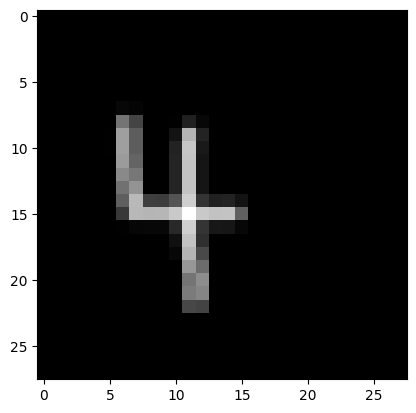

torch.Size([1, 28, 28])

In [38]:
image_tensor = test_transform(image)
plt.imshow(image_tensor.permute(1, 2, 0), cmap='gray')
plt.show()
image_tensor.shape

In [39]:
model(image_tensor.unsqueeze(0).to(device)).argmax(1)

tensor([4], device='cuda:0')

In [ ]:
dataloader_testing.dataset.dataset.classes

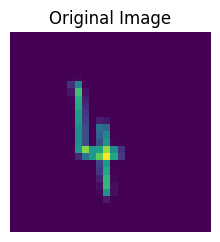

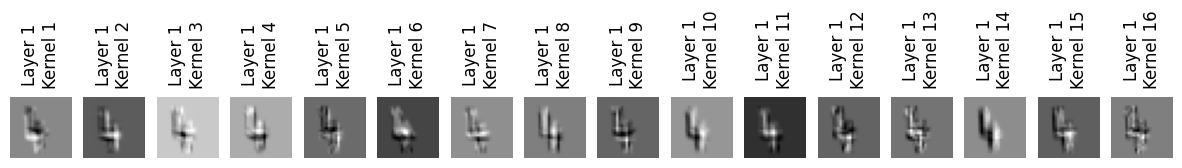

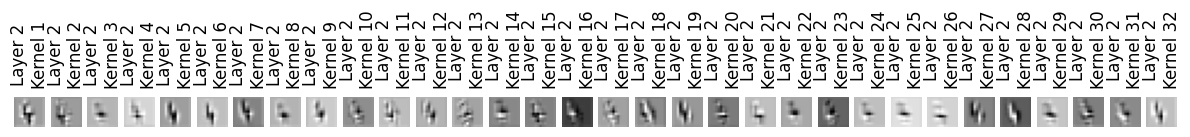

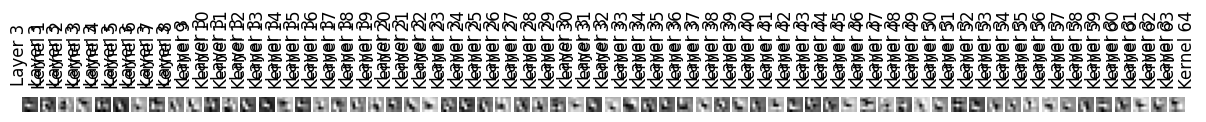

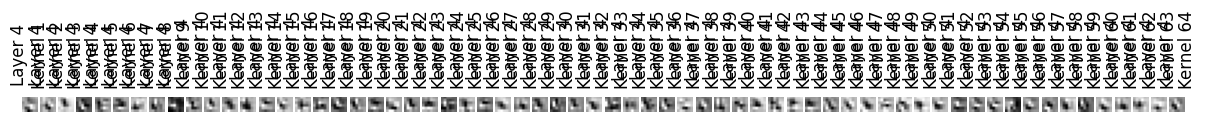

9


In [99]:
# prompt: plot each layer in the network

import matplotlib.pyplot as plt
from PIL import Image
def visualize_kernels(model, dataloader, device=device):

    if type(dataloader)==str:
        image = Image.open(dataloader).convert('L')
        image_tensor = test_transform(image).unsqueeze(0).to(device)
        inputs = image_tensor
        classes = dataloader_testing.dataset.dataset.classes
    else:
        # Get a single batch from the test dataloader
        inputs, _ = next(iter(dataloader))
        inputs = inputs.to(device)
        classes=  dataloader.dataset.dataset.classes
        # Forward pass through the model

    model.to(device)
    model.eval()


    activations = []

    def hook_fn(module, input, output):
        if isinstance(module, torch.nn.Conv2d):
            activations.append(output)

    hooks = []
    for name, layer in model.named_modules():
        if isinstance(layer, torch.nn.Conv2d):
            hooks.append(layer.register_forward_hook(hook_fn))

    # Perform a forward pass to trigger hooks
    with torch.no_grad():
        output = model(inputs)

    # Remove hooks
    for hook in hooks:
        hook.remove()

    # Plot the original image
    plt.figure(figsize=(15, 15))
    plt.subplot(1, len(activations) + 1, 1)
    plt.imshow(inputs[0].cpu().permute(1, 2, 0))
    plt.title('Original Image')
    plt.axis('off')

    # Plot the activations of each Conv2d layer
    for i, activation in enumerate(activations):
        num_kernels = activation.shape[1]
        plt.figure(figsize=(15, 15))
        for j in range(num_kernels):
            plt.subplot(1, num_kernels, j + 1)
            plt.imshow(activation[0, j].cpu().detach().numpy(), cmap='gray')
            plt.title(f'Layer {i + 1}\nKernel {j + 1}', rotation=90, va='bottom')
            plt.axis('off')
    plt.show()
    print(classes[output[0].unsqueeze(0).argmax(1).item()])
# Visualize the kernels for a single image in the test dataloader
visualize_kernels(model, "./test.jpeg")

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("gpiosenka/cards-image-datasetclassification")

print("Path to dataset files:", path)


Path to dataset files: /root/.cache/kagglehub/datasets/gpiosenka/cards-image-datasetclassification/versions/2


In [ ]:
import os
os.listdir(path)
train_path = path+"/train"
test_path = path +"/test"
valid_path = path+"/valid"
transform_card = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()

])
train_dataloader = create_dataset_loader(train_path,transform_card,imageheight=224,imagewidth=224)
test_dataloader = create_dataset_loader(test_path,transform_card,imageheight=224,imagewidth=224)
valid_dataloader = create_dataset_loader(valid_path,transform_card,imageheight=224,imagewidth=224)

In [ ]:
len(train_dataloader)

477

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import confusion_matrix
import seaborn as sns
import torch.functional as F
import torch
import torch.nn.init as init
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class CNN_Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extract= nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=11, padding=1), #16x16x16x 216x216
            nn.ELU(),
            nn.AvgPool2d(2,2), #16x108x108
            nn.Conv2d(16,32,kernel_size=3, padding=1), #32x108x108
            nn.ELU(),
            nn.AvgPool2d(2,2) , #32x54x54
            nn.Conv2d(32,32,kernel_size=3, padding =1) , # 32 x54x54
            nn.ELU(),
            nn.AvgPool2d(2,2), # 32x 27x27
            nn.Conv2d(32,32,kernel_size=3, padding =1) ,
            nn.ELU(),
            nn.AvgPool2d(2,2), # 32x 13x13

        )
        self.bn1 = nn.BatchNorm2d(32)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32*13*13, 256),
            nn.ELU(),
            nn.Linear(256, 128),
            nn.ELU(),
            nn.Linear(128,53)
        )
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def forward(self,x):
        # try:
        x = self.feature_extract(x)

        x= self.bn1(x)
        x= self.classifier(x)
        # except:
        #   for image in x:
        #     image = image.unsqueeze(0)
        #     plt.imshow(image[0].permute(1, 2, 0).to('cpu').numpy())
        #     plt.show()
        #     print(x.shape)
        return x
model = CNN_Model().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

Epoch 1/5, Train Loss: 3.1112, Train Accuracy: 0.2522, Val Loss: 1.9618, Val Accuracy: 0.4113
Epoch 2/5, Train Loss: 2.0004, Train Accuracy: 0.4524, Val Loss: 1.6523, Val Accuracy: 0.5472
Epoch 3/5, Train Loss: 1.4592, Train Accuracy: 0.6019, Val Loss: 1.2084, Val Accuracy: 0.6453
Epoch 4/5, Train Loss: 0.9900, Train Accuracy: 0.7247, Val Loss: 1.0666, Val Accuracy: 0.6868
Epoch 5/5, Train Loss: 0.6171, Train Accuracy: 0.8286, Val Loss: 1.1598, Val Accuracy: 0.7434


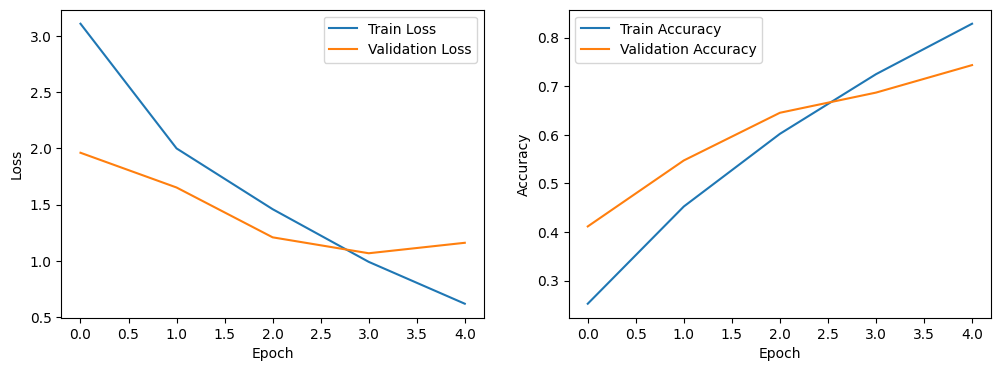

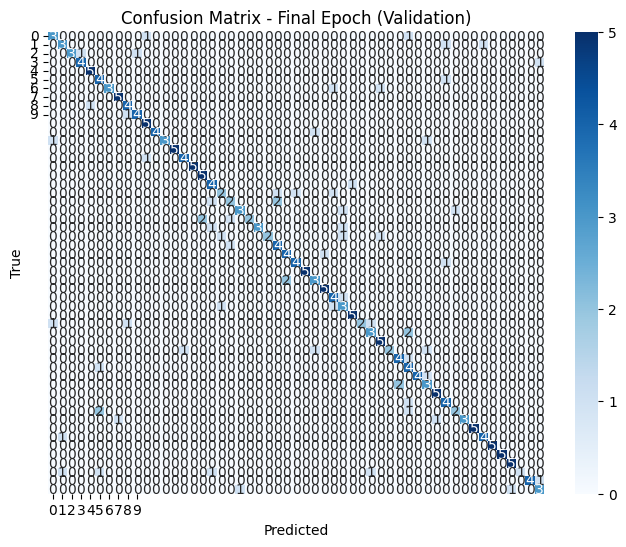

In [ ]:
num_epochs = 5 # Adjust the number of epochs as needed
epoch_losses, epoch_accuracies, val_losses, val_accuracies = train_model(model, train_dataloader, valid_dataloader, num_epochs, criterion, optimizer, scheduler)


Epoch 1/5, Train Loss: 0.2394, Train Accuracy: 0.9368, Val Loss: 0.9199, Val Accuracy: 0.7849
Epoch 2/5, Train Loss: 0.1348, Train Accuracy: 0.9693, Val Loss: 0.9204, Val Accuracy: 0.7962
Epoch 3/5, Train Loss: 0.0945, Train Accuracy: 0.9805, Val Loss: 0.8910, Val Accuracy: 0.7925
Epoch 4/5, Train Loss: 0.0667, Train Accuracy: 0.9877, Val Loss: 0.9682, Val Accuracy: 0.7925
Epoch 5/5, Train Loss: 0.0501, Train Accuracy: 0.9913, Val Loss: 0.9537, Val Accuracy: 0.7925


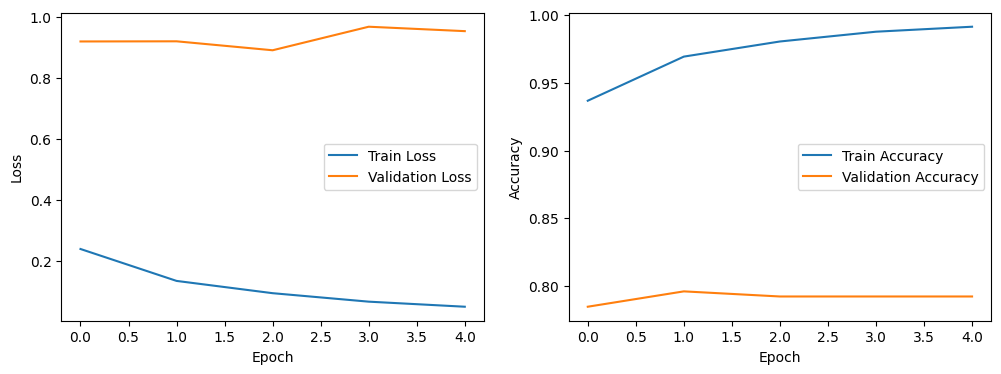

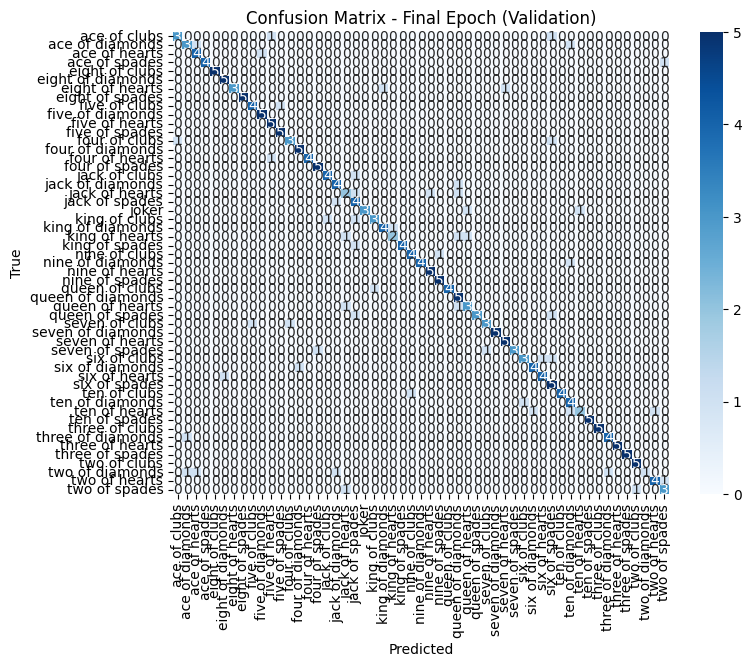

In [ ]:
epoch_losses, epoch_accuracies, val_losses, val_accuracies = train_model(model, train_dataloader, valid_dataloader, num_epochs, criterion, optimizer, scheduler)


In [ ]:
test_dataloader.dataset.classes

['ace of clubs',
 'ace of diamonds',
 'ace of hearts',
 'ace of spades',
 'eight of clubs',
 'eight of diamonds',
 'eight of hearts',
 'eight of spades',
 'five of clubs',
 'five of diamonds',
 'five of hearts',
 'five of spades',
 'four of clubs',
 'four of diamonds',
 'four of hearts',
 'four of spades',
 'jack of clubs',
 'jack of diamonds',
 'jack of hearts',
 'jack of spades',
 'joker',
 'king of clubs',
 'king of diamonds',
 'king of hearts',
 'king of spades',
 'nine of clubs',
 'nine of diamonds',
 'nine of hearts',
 'nine of spades',
 'queen of clubs',
 'queen of diamonds',
 'queen of hearts',
 'queen of spades',
 'seven of clubs',
 'seven of diamonds',
 'seven of hearts',
 'seven of spades',
 'six of clubs',
 'six of diamonds',
 'six of hearts',
 'six of spades',
 'ten of clubs',
 'ten of diamonds',
 'ten of hearts',
 'ten of spades',
 'three of clubs',
 'three of diamonds',
 'three of hearts',
 'three of spades',
 'two of clubs',
 'two of diamonds',
 'two of hearts',
 'two o

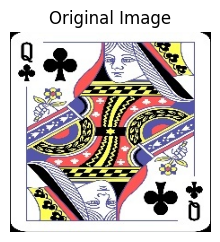

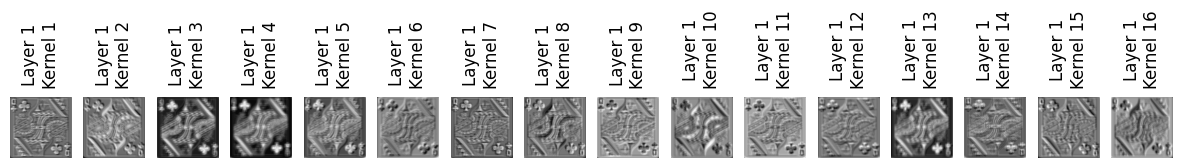

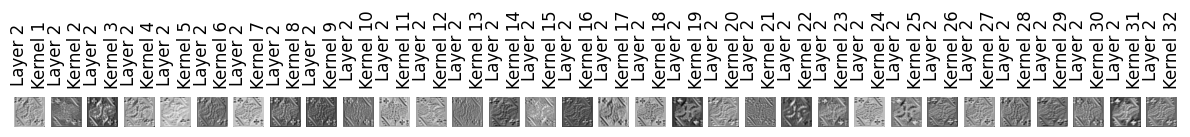

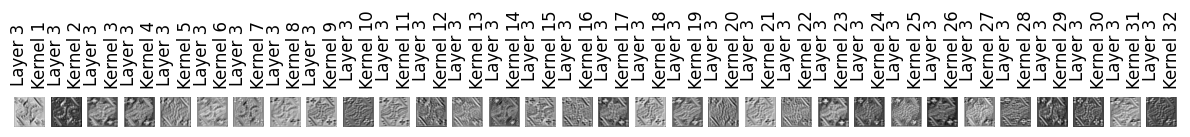

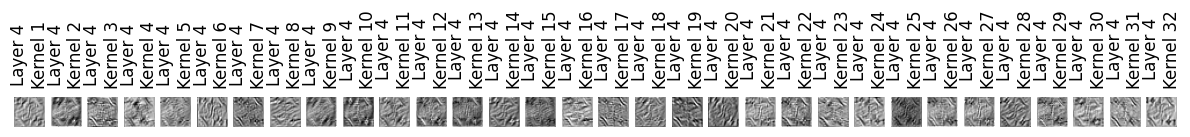

queen of clubs


In [ ]:
visualize_kernels(model, test_dataloader)

In [ ]:
img, label = next(iter(test_dataloader))
print(img.shape)
img = img[0]
label = label[0]
img = img.unsqueeze(0).to(device)
img.shape

torch.Size([16, 3, 224, 224])


torch.Size([1, 3, 224, 224])

In [ ]:
model(img).argmax(1).item()

2